In [1]:
library(rvest)
library(tidyverse)
library(tidymodels)
library(repr)
install.packages("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()         masks stats::filter()
✖ readr::guess_encoding() masks rvest::guess_encoding()
✖ dplyr::lag()            masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed

In [2]:
# loading in the data from the web 
url <- "raw.githubusercontent.com/marlotea/dsci_group_project/main/data/heart.csv"

download.file(url, destfile = "heart.csv")
heart_data <- read_csv("heart.csv") |>
    mutate(target = as_factor(target))

head(heart_data)

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
58,0,0,100,248,0,0,122,0,1.0,1,0,2,1


In [3]:
set.seed(1000)

clean_heart <- heart_data |>
    select(thalach, target) 

heart_split <- initial_split(clean_heart, prop = 0.75, strata = target)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

heart_recipe <- recipe(target ~ thalach, data = heart_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit(data = heart_training)

In [4]:
heart_test_predictions <- predict(heart_fit, heart_testing) |>
    bind_cols(heart_testing)

# computing the accuracy of k = 3
acc_k3 <- heart_test_predictions |>
    metrics(truth = target, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

acc_k3

[1] 0.6031128

In [5]:
heart_vfold <- vfold_cv(heart_training, v = 5, strata = target)

heart_fit_5fold <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit_resamples(resamples = heart_vfold) 

heart_fit_5fold |>
    collect_metrics()

heart_vfold2 <- vfold_cv(heart_training, v = 10, strata = target)

heart_fit_10fold <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit_resamples(resamples = heart_vfold2) 

heart_fit_10fold |>
    collect_metrics()

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.6340567,5,0.009590791,Preprocessor1_Model1
roc_auc,binary,0.6884990,5,0.016294658,Preprocessor1_Model1


.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.6221660,10,0.01011426,Preprocessor1_Model1
roc_auc,binary,0.6808395,10,0.01122174,Preprocessor1_Model1


In [6]:
# v = 5

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

heart_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec2) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics()
    
accuracies <- heart_results |>
  filter(.metric == "accuracy")

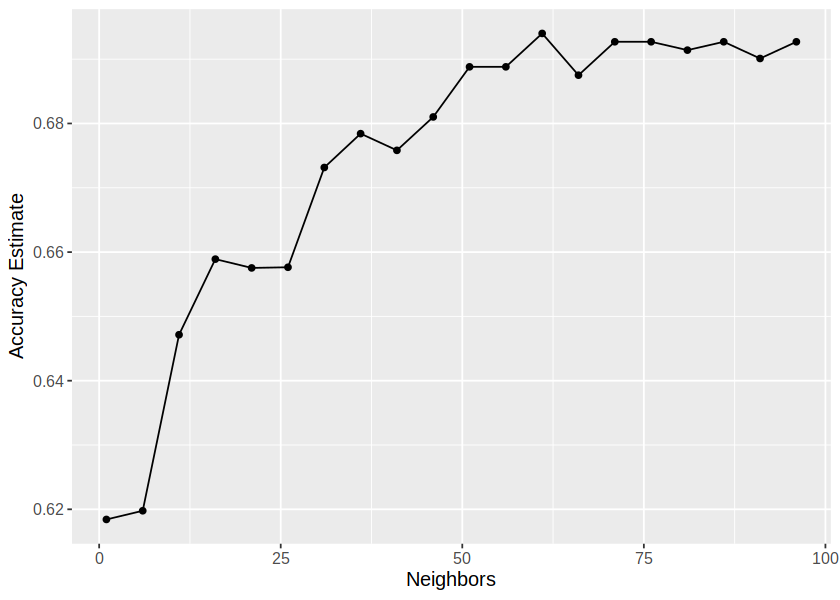

In [7]:
options(repr.plot.width = 7, repr.plot.height = 5)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12))

accuracy_vs_k

In [8]:
best_k <- accuracies |>
          arrange(desc(mean)) |>
          slice(1) |>
          select(neighbors)

best_k

neighbors
<dbl>
61


neighbors
<dbl>
61


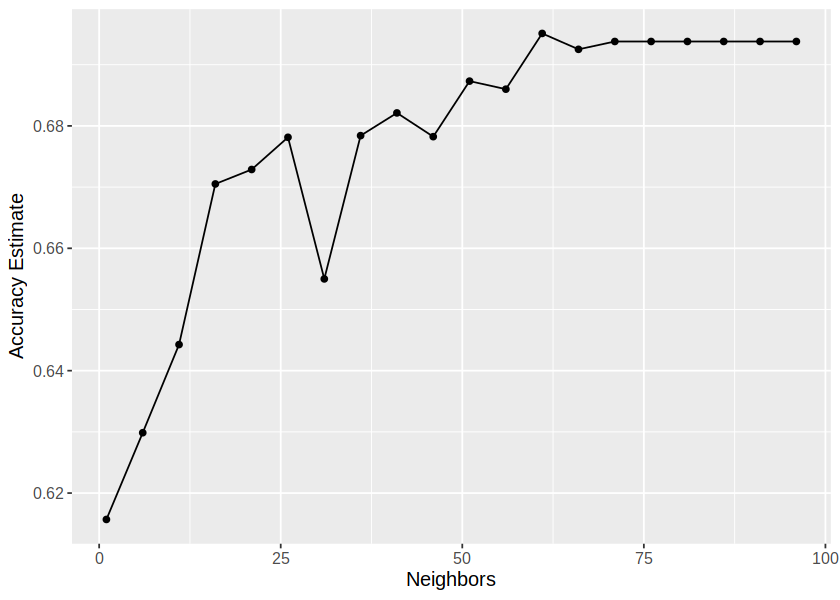

In [9]:
# v = 10 (i honestly don't know the difference)

heart_results2 <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec2) |>
    tune_grid(resamples = heart_vfold2, grid = k_vals) |>
    collect_metrics()
    
accuracies2 <- heart_results2 |>
  filter(.metric == "accuracy")

accuracy_vs_k2 <- ggplot(accuracies2, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12))

accuracy_vs_k2

best_k2 <- accuracies2 |>
          arrange(desc(mean)) |>
          slice(1) |>
          select(neighbors)

best_k2

In [10]:
# would it be best to use the graph where v = 5 since v = 5 gives us a higher accuracy mean than v = 10?

In [11]:
heart_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 61) |>
      set_engine("kknn") |>
      set_mode("classification")

heart_fit2 <- workflow() |>
      add_recipe(heart_recipe) |>
      add_model(heart_spec2) |>
      fit(data = heart_training)

heart_predictions <- predict(heart_fit2, heart_testing) |>
bind_cols(heart_testing)

heart_metrics <- heart_predictions |>
metrics(truth = target, estimate = .pred_class)

heart_conf_mat <- heart_predictions |> 
conf_mat(truth = target, estimate = .pred_class)

heart_predictions
heart_metrics
heart_conf_mat

.pred_class,thalach,target
<fct>,<dbl>,<fct>
0,122,1
0,144,0
0,122,0
1,165,1
1,155,0
0,142,0
0,115,0
1,182,1
0,105,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7159533
kap,binary,0.4306394


          Truth
Prediction  0  1
         0 85 33
         1 40 99